In [1]:
#The following code is written using GlobalSkyModel and not GlobalSkyModel2016. The difference is just the units, and that can be modified anytime.

import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
import math
import ephem

%matplotlib inline

from pygsm import GlobalSkyModel
from ms_fit_joint_inf import ms_fit_inf
import maxsmooth
from maxsmooth.DCF import smooth

from astropy.time import Time
from astropy.coordinates import Galactic, SkyCoord, FK5, EarthLocation, AltAz, Angle
import astropy.units as u

import pandas as pd
from scipy.interpolate import Rbf, InterpolatedUnivariateSpline



In [2]:
h = 6.62607157e-34
k = 1.3806488e-23
c = 2.99792458e+08
TCMB = 2.72548
f_start = 2
f_stop = 4
No_of_Channels = 41
Channel_width = 0.05
N_SIDE = 16
T_hot = 373
T_cold = 273         #T_cold and T_hot in Kelvins
Time_in_UTC = '2022-05-20 1:45:00'  
latitude = 13.067439
longitude = 80.237617       #Latitude and longitude in degrees
altitude = 0            #Altitude in meters
alpha = 0.0065            #Temp. lapse rate (deg C per meter)
PI = 3.14159265
Noise_int_time = 2.7e10
Trx = 14
T_atm = 1
freqs = np.linspace(f_start,f_stop, No_of_Channels)
CMB_Int = np.empty(No_of_Channels)
P_hot = np.empty(No_of_Channels)
P_cold = np.empty(No_of_Channels)
P_dif = np.empty(No_of_Channels)
cross_real = [0]*No_of_Channels
cross_imag = [0]*No_of_Channels
sumwt = [0]*No_of_Channels
sigma = [0]*No_of_Channels


def refraction(alt_in_deg, altitude):
    pres = 1010.*math.pow((1-6.5/288000*altitude),5.255)
    if (altitude>11000):
        temp = 211.5
    else:
        temp = 283.0 - (alpha * altitude)
    R = 1.02/math.tan((alt_in_deg + (10.3/(alt_in_deg + 5.11)))*(PI/180))
    if (alt_in_deg == 90):
        R = R+ 0.0019279
    tpcor = (pres/1000) * (283/temp)
    R =  tpcor*(R/60)
    return alt_in_deg +R


def beam_def(freq, az, alt):
    if (alt<=0):
        return 0
    else:
        return (math.sin(alt*PI/180)*math.sin(alt*PI/180))
    

In [3]:
fre_cubed = np.empty(No_of_Channels)
exp = np.empty(No_of_Channels)


gsm = GlobalSkyModel(freq_unit='GHz')
spectrum = gsm.generate(freqs)*1.38e-23    
#PyGSM pack has antenna units. Converted to SI units above
#print(spectrum.shape)

spec = hp.pixelfunc.ud_grade(spectrum, N_SIDE)

CMB_Int = (2*h*freqs*1e9*freqs*1e9*freqs*1e9)/(c*c*np.exp(h*freqs*1e9/k*TCMB)-1)
P_hot = 2*k*T_hot*(((h*freqs)/(k*T_hot))/(np.exp((h*freqs)/(k*T_hot))-1))
P_cold = 2*k*T_cold*(((h*freqs)/(k*T_cold))/(np.exp((h*freqs)/(k*T_cold))-1))
P_dif = P_hot - P_cold
# #print(P_dif)




In [4]:

NPIX = hp.nside2npix(N_SIDE)
df = pd.read_csv(r'/home/dhashin/workspace/APSERa/total_spec_new.txt',sep= "    " ,header = None)
df.reset_index(drop=True, inplace=True)
df.columns = ["Frequency","Intensity"]

x = df["Frequency"]
y= df["Intensity"]

ius = InterpolatedUnivariateSpline(x, y)

Rec_int = ius(freqs)


/tmp/ipykernel_21873/1474476065.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(r'/home/dhashin/workspace/APSERa/total_spec_new.txt',sep= "    " ,header = None)


In [6]:
i=1
while i<NPIX:           #Working on each pixel
    coords = hp.pixelfunc.pix2ang(16, i , nest = False, lonlat = True)          #Gives l and b coordinates for each pixel
    gc = SkyCoord(l = coords[0]*u.degree, b= coords[1]*u.degree, frame = 'galactic')
        
        #Now, the coordinates in Galactic frame is changed to equitorial frame below
    equi = gc.transform_to(AltAz(obstime = Time_in_UTC, location = EarthLocation(lat = latitude*u.deg, lon=longitude*u.deg, height=altitude*u.m)))
    alt = equi.alt.value
    new_alt = refraction(alt, altitude) 
    
    
    
    j=0
    while j< No_of_Channels:
        cwt = beam_def(freqs[j],equi.az.value, new_alt)
        
        if (cwt>0):
            intensity = CMB_Int[j] + Rec_int[j] +spec[j][i-1]
            final_temp = (intensity/P_dif[j])*(T_hot-T_cold)
            cross_real[j] = cross_real[j] + cwt*final_temp
            sumwt[j] = sumwt[j]+ cwt
        
        j = j+1
    
    i = i+1
    
    
i=0    
while(i< No_of_Channels):
    if sumwt[i]>0:
        cross_real[i] = cross_real[i]/sumwt[i]
    i = i+1
    

            

In [7]:
#Adding thermal noise to the final spectrum    
#For the total power radiometer:

sigma = (np.array(cross_real) + Trx+ T_atm)/ math.sqrt(Channel_width*1e6*Noise_int_time)

#Generating array of random numbers(of length = No.of channels) with mean =0, std = 1 
array = np.random.normal(0,1,No_of_Channels)
print(array)

cross_real = cross_real + array*sigma
cross_imag = cross_imag + array*sigma


[-0.31597443  1.12733564 -0.33915602 -0.42815784 -0.54555449  0.75974973
  0.23329227  0.00295308 -2.2204768   0.01395832 -0.17314425  0.16438911
 -1.40159645 -0.91435447  1.09078283  0.3974777   0.76754     0.59371363
 -0.95301164 -0.88356368  0.84549374  0.99490514 -1.50515138  0.54658117
 -0.07058737  0.85225965  0.61750083  1.26369383 -0.55091846 -0.52579169
 -0.14394077  0.236394    0.08063103  0.1348572   0.86154155 -0.33859076
 -0.43746951  0.55944763  0.83414801  0.42037798  0.27828154]


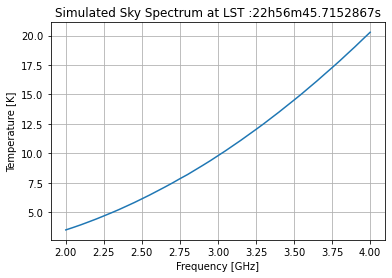

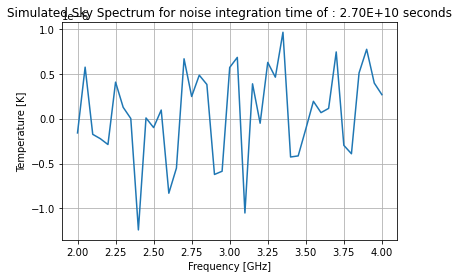

In [8]:
Obs = ephem.Observer()
t = Time(Time_in_UTC, scale='utc',location=(longitude, latitude))
lst = t.sidereal_time('apparent')


plt.plot(freqs, cross_real)
plt.xlabel('Frequency [GHz]')
plt.ylabel('Temperature [K]')
plt.title('Simulated Sky Spectrum at LST :%s'%lst)
plt.grid()
plt.show()

plt.plot(freqs, cross_imag)
plt.xlabel('Frequency [GHz]')
plt.ylabel('Temperature [K]')
plt.title('Simulated Sky Spectrum for noise integration time of : %.2E seconds'%Noise_int_time)
plt.grid()
plt.show()

##################################################
--------------------OPTIMUM RESULT--------------------
Time: 0.1196751594543457
Polynomial Order: 8
Number of Constrained Derivatives: 6
Signs : [-1 -1  1 -1  1 -1]
Objective Function Value: 0.0013343288890388509
Parameters: [[ 9.79836290e+00  8.38692358e+00  2.09796615e+00  1.71269816e-02
  -7.63538431e-03  3.21940934e-03 -9.51996119e-04  1.32514213e-04]]
Method: qp-sign_flipping
Model: difference_polynomial
Constraints: m >= 2
Zero Crossings Used? (0 signifies Yes
 in derivative order "i"): {'0': 1, '1': 1}
--------------------------------------------------
##################################################
[ 3.48033919  3.70001317  3.92951878  4.16892458  4.41829362  4.67768374
  4.947148    5.22673497  5.51648912  5.81645111  6.12665804  6.44714383
  6.77793937  7.11907285  7.47056995  7.83245407  8.2047465   8.58746667
  8.98063228  9.38425944  9.7983629  10.22295608 10.65805131 11.10365984
 11.55979203 12.02645738 12.50366466 12.

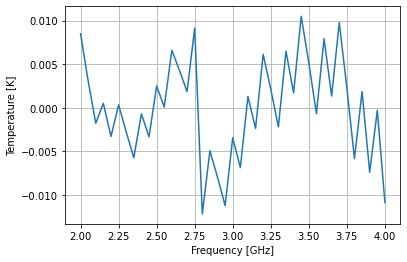

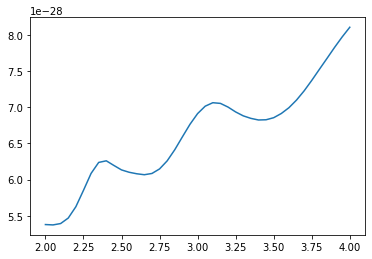

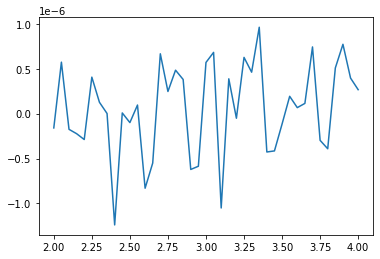

In [9]:
result = smooth(freqs, cross_real,8)
print(result.y_fit)

plt.plot(freqs,cross_real - result.y_fit)
plt.grid()
plt.xlabel('Frequency [GHz]')
plt.ylabel('Temperature [K]')
plt.show()

plt.plot(freqs, Rec_int)
plt.show()
  
plt.plot(freqs, cross_imag)
plt.show()

In [10]:
print(ms_fit_inf(freqs, cross_real, norder = 8)) 

+------------------+--------------------+
|    Parameter     |       Value        |
+------------------+--------------------+
|       flag       |    41 elements     |
|      error       |    41 elements     |
|       xtol       |       1e-06        |
|       ftol       |       1e-06        |
|      domain      |      lin_lin       |
|     maxiter      |      100000.0      |
|      maxfev      |      100000.0      |
|       algo       |    Nelder-Mead     |
|      norder      |         8          |
|       temp       |        0.1         |
|     stepsize     |        0.1         |
|      niter       |         1          |
| basin_iter_loops |         10         |
|       xmin       |        2.0         |
|       xmax       |        4.0         |
|     rescale      |        True        |
|       seed       |         1          |
|     additive     |        True        |
|      joint       |       False        |
|      signal      |      [False]       |
|     add_ini      |        0.0   